# Capstone project

This workspace predicts churn for the Sparkify Capstone Project. Predicting churn rates is a challenging and common problem. The project uses Spark running on IBM Cloud on a medium-sized dataset (230MB). 

In [1]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F

import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from scipy import stats
%matplotlib inline

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191216203904-0000
KERNEL_ID = f3db5bf6-5b4e-4d26-9fa8-cd5dc339c503


# Load and Clean Dataset
The dataset file is `medium-sparkify-event-data.json`. The dataset is loaded, cleaned, and checked for invalid or missing data (e.g. Logged Out users are filtered).

The dataset contains in total `543,705 records` spread across `448 users`, out of which 99 have visited the "Cancellation Confirmation" page (i.e. churned). The dataset spans `2 months of actions` (1-Oct-18 to 1-Dec-18) for the users.

In [2]:
#Set up IBM cloud Sparkify Project Workspace
import ibmos2spark
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-e49c7311-53ef-4d48-9d22-f328c8e4e8fa',
    'iam_service_endpoint': 'https://iam.eu-gb.bluemix.net/oidc/token',
    'api_key': '2vwi5rVjvggjTe2RlluSKmXx2S-0oIW5R9wnsN7lpUWJ'
}

configuration_name = 'os_ba61e0ca149a474794f05efc9f6fa987_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

spark = SparkSession.builder.getOrCreate()

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-sb5ykeq71ybrbu'))
df.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [3]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
# Count records in the dataset
df.count()

543705

In [5]:
# Filter Logged Out users
df = df.filter(df.userId != "")

In [6]:
# Check if sessionId or userId are null
print("Number of null sessionId or userId rows: {}".format(\
    df.filter("userId is null").count() + df.filter("sessionId is null").count()))

Number of null sessionId or userId rows: 0


In [7]:
# Count unique users and the ones that visited the "Cancellation Confirmation" page
print("Number of users in the dataset is: {}, out of which:".format(\
    df.select('userId') \
    .dropDuplicates() \
    .count()))

print("Users that visited the \"Cancellation Confirmation\" page: {}".format(\
    df.filter(df.page == "Cancellation Confirmation")\
    .select('userId') \
    .dropDuplicates() \
    .count()))

Number of users in the dataset is: 448, out of which:
Users that visited the "Cancellation Confirmation" page: 99


In [8]:
# Store timestamp in 'time' column and print min and max timestamps
df = df.withColumn("time", F.to_timestamp(F.col("ts")/1000))

print('Min and max times are:')
print(df.agg({"time": "min"}).collect()[0])
print(df.agg({"time": "max"}).collect()[0])

Min and max times are:
Row(min(time)=datetime.datetime(2018, 10, 1, 0, 0, 11))
Row(max(time)=datetime.datetime(2018, 12, 1, 0, 1, 6))


# Exploratory Data Analysis

### Churn frequency
`Churn` is defined using the `Cancellation Confirmation` page (presumably once a user visits this page he has deleted his accout), which happen for both paid and free users. Since 99 of 448 users have churned, the `churn frequency is 22%`.

### Data Exploration
To observe the behavior for users who stayed vs. users who churned, user attributes are computed and compared for churn and non-churn users. These (per-user) attributes are:
- Number (count) of each visited page
- Gender
- Session statistics
    - Avg. length of listened songs
    - Avg. number of items (which are mostly songs) in one session
    - Number (count) of sessions
- Subscription level (free or paid)
- Number of days since registration

### Data understanding
Comparing these attributes between churned and non-churned users, reveals that **users that cancel tend to be new, and less engaged with the system**. In particular:
- Users that cancel visit fewer "engagement" pages and relatively more "negative" pages vs. users that do not cancel. Examples of "engagement" pages: `Add Friend`, `Add to Playlist`, `Save Settings`, `Thumbs Up`. Examples of "negative" pages: `Roll Advert`, `Thumbs Down`.
- Users that cancel have fewer sessions vs. users that do not cancel (attribute: count of unique `sessionId`)
- Users that cancel have registered recently (attribute: `days_registration`)


In [9]:
# Define churn
flag_cancellation_event = F.udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df.withColumn("cancel_event", flag_cancellation_event("page"))\
    .select('userId', 'cancel_event') \
    .groupBy('userId') \
    .agg({'cancel_event':'sum'}) \
    .withColumnRenamed('sum(cancel_event)', 'cancel_event') \
    .groupBy('cancel_event') \
    .agg({'userId':'count'}) \
    .sort(F.desc('cancel_event')) \
    .show()

+------------+-------------+
|cancel_event|count(userId)|
+------------+-------------+
|           1|           99|
|           0|          349|
+------------+-------------+



In [10]:
# Function to calculate for each user the visited pages
# Function includes the possibility to restrict the attribute calculation over a desired
# time frame (time filter column with 1/0 needs to be included in data frame)

def users_by_page_function(df, time_filter = None):
    '''
    Calculate for each user the number (count) of visited pages
    
    Parameters
    ----------
    df : Spark DataFrame
        Dataframe with log data. Needs to contain columns "userId", and "page"
    time_filter : String, optional
        Name of time filter column (containing 1/0), if the statistics needs
        to be restricted to a time period. The default is None.

    Returns
    -------
    users_by_page : Spark DataFrame
        For each user (as row) count the number of page visits (pages as columns)

    '''
    
    # Calculate unique pages as input for pivot
    unique_pages = [row.page for row in\
                df.select("page").dropDuplicates().sort("page").collect()]
    
    if (time_filter is not None):
        df = df.filter(df[time_filter] == 1)\

    # Calculate user by pages pivot (as count of rows)        
    users_by_page = df\
                    .select("userId", "page")\
                    .groupBy("userId")\
                    .pivot("page", unique_pages)\
                    .count()

    return users_by_page

users_by_page = users_by_page_function(df)
users_by_page.show(5)

+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|200002|    1|         2|              6|     1|                        1|        3| null|   1|  23|    11|     310|         11|         null|       2|            null|             1|          5|       15|      2|
|100010| null|         3|              1|     1|                        1|     null| null|null|   3|     1|      96|         22|         null|  

In [11]:
# Function to calculate for each user its gender

def users_by_gender_function(df):
    '''
    Define for each user its gender
    
    Parameters
    ----------
    df : Spark DataFrame
        Dataframe with log data. Needs to contain columns "userId", and "gender"

    Returns
    -------
    users_by_gender : Spark DataFrame
        For each user (as row) specifies its gender (0/1) (gender as columns)

    '''
            
    # Calculate user by gender pivot (as count of rows)
    users_by_gender = df\
                    .groupBy("userId")\
                    .pivot("gender", ['M', 'F'])\
                    .count()
    
    # Rename output columns
    users_by_gender = users_by_gender \
        .withColumnRenamed('M', 'is_M') \
        .withColumnRenamed('F', 'is_F')
    
    # Change values higher than 0 to 1
    for changed_column in users_by_gender.schema.names:
        if changed_column != 'userId':
            users_by_gender = users_by_gender\
                .withColumn(changed_column, F.when(users_by_gender[changed_column] > 0, 1))

    return users_by_gender

users_by_gender = users_by_gender_function(df)
users_by_gender.show(5)

+------+----+----+
|userId|is_M|is_F|
+------+----+----+
|   296|null|   1|
|100010|null|   1|
|200002|   1|null|
|   125|   1|null|
|     7|   1|null|
+------+----+----+
only showing top 5 rows



In [12]:
# Function to calculate for each user its session statistics
# Function includes the possibility to restrict the attribute calculation over a desired
# time frame (time filter column with 1/0 needs to be included in data frame)

def users_by_session_function(df, time_filter = None):
    '''
    Calculate for each user its session statistics:
        avg_length (avg. length of songs)
        avg_itemInSession (count of executed items(mostly songs) in a session)
        sessionId (count of distinct sessions)
    
    Parameters
    ----------
    df : Spark DataFrame
        Dataframe with log data. Needs to contain columns 'userId', 'sessionId',
        'itemInSession', 'length'
    time_filter : String, optional
        Name of time filter column (containing 1/0), if the statistics needs
        to be restricted to a time period. The default is None.

    Returns
    -------
    users_by_session : Spark DataFrame
        For each user (as row) specifies its session statistics (as columns)

    '''
    
    if (time_filter is not None):
        df = df.filter(df[time_filter] == 1)\
            
    # Calculate user statistics
    users_by_session = df \
        .select('userId', 'sessionId', 'itemInSession', 'length') \
        .groupby('userId', 'sessionId') \
        .agg({'itemInSession': 'max', 'length': 'avg'}) \
        .withColumnRenamed('max(itemInSession)', 'max_itemInSession') \
        .withColumnRenamed('avg(length)', 'avg_length') \
        .groupby('userId') \
        .agg({'sessionId': 'count', 'max_itemInSession': 'avg', 'avg_length': 'avg'}) \
        .withColumnRenamed('count(sessionId)', 'sessionId') \
        .withColumnRenamed('avg(max_itemInSession)', 'avg_itemInSession') \
        .withColumnRenamed('avg(avg_length)', 'avg_length')

    return users_by_session

users_by_session = users_by_session_function(df)
users_by_session.show(5)

+------+------------------+------------------+---------+
|userId|        avg_length| avg_itemInSession|sessionId|
+------+------------------+------------------+---------+
|   296|265.44961898747846|              30.6|        5|
|200002|247.33117322512322|              83.2|        5|
|100010| 269.2639089535388|              68.5|        2|
|   125| 281.4469188018868|27.666666666666668|        3|
|     7|254.45288840029949|40.666666666666664|       15|
+------+------------------+------------------+---------+
only showing top 5 rows



In [13]:
# Function to calculate for each user its latest subscription level

def user_by_level_function(df):
    '''
    Define for each user its latest subscription level
    
    Parameters
    ----------
    df : Spark DataFrame
        Dataframe with log data. Needs to contain columns 'userId', 'time', 'level'

    Returns
    -------
    user_by_level : Spark DataFrame
        For each user (as row) specifies its subscribtion level (as columns)

    '''
    
    # Find the max time for each user
    w = Window.partitionBy('userId')
    user_by_time_level = df\
        .select('userId', 'time', 'level') \
        .withColumn('maxtime', F.max('time').over(w)) \
        .where(F.col('time') == F.col('maxtime')) \
        .drop('maxtime') \
        .dropDuplicates()
    
    # Calculate user by level pivot (as count of rows)
    user_by_level = user_by_time_level\
        .groupBy("userId") \
        .pivot("level", ['free', 'paid']) \
        .count()
    
    # Rename output columns
    user_by_level = user_by_level \
        .withColumnRenamed('free', 'is_free') \
        .withColumnRenamed('paid', 'is_paid')
    
    # Change values higher than 0 to 1
    for changed_column in user_by_level.schema.names:
        if changed_column != 'userId':
            user_by_level = user_by_level\
                .withColumn(changed_column, F.when(user_by_level[changed_column] > 0, 1))

    return user_by_level

user_by_level = user_by_level_function(df)
user_by_level.show(5)

+------+-------+-------+
|userId|is_free|is_paid|
+------+-------+-------+
|100010|      1|   null|
|200002|   null|      1|
|   296|   null|      1|
|   125|      1|   null|
|   124|   null|      1|
+------+-------+-------+
only showing top 5 rows



In [14]:
# Function to calculate for each user the number of days since registration

def user_by_time_function(df):
    '''
    Calculate for each user the number of days since registration
    
    Parameters
    ----------
    df : Spark DataFrame
        Dataframe with log data. Needs to contain columns 'userId', 'time', 'registration'

    Returns
    -------
    user_by_time : Spark DataFrame
        For each user (as row) specifies the number of days since registration (as columns)

    '''
            
    # Find the max time for each user
    w = Window.partitionBy('userId')
    user_by_time_level = df\
        .select('userId', 'time', 'registration') \
        .withColumn('maxtime', F.max('time').over(w)) \
        .where(F.col('time') == F.col('maxtime')) \
        .drop('maxtime') \
        .withColumn('registration', F.to_timestamp(F.col('registration')/1000)) \
        .dropDuplicates()
    
    user_by_time = user_by_time_level \
        .withColumn('days_registration',\
                    F.datediff(user_by_time_level['time'],\
                               user_by_time_level['registration']))\
        .select('userId', 'days_registration')

    return user_by_time

user_by_time = user_by_time_function(df)
user_by_time.show(5)

+------+-----------------+
|userId|days_registration|
+------+-----------------+
|100010|               14|
|200002|               54|
|   296|               26|
|   125|              106|
|   124|              112|
+------+-----------------+
only showing top 5 rows



In [15]:
# Merge all user related attributes into one Spark data frame
# Print: Schema, number of users, and first 5 rows

users_by_attributes = users_by_page\
    .join(users_by_gender, ['userId'], how='full') \
    .join(users_by_session, ['userId'], how='full') \
    .join(user_by_level, ['userId'], how='full') \
    .join(user_by_time, ['userId'], how='full') \
    .fillna(0) \
    .collect()

users_by_attributes = spark.createDataFrame(users_by_attributes)
print(users_by_attributes.printSchema())
print('Number of users in the dataset is: {}'.format(users_by_attributes.count()))
users_by_attributes.show(5)

root
 |-- userId: string (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Cancel: long (nullable = true)
 |-- Cancellation Confirmation: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- is_M: long (nullable = true)
 |-- is_F: long (nullable = true)
 |-- avg_length: double (nullable = true)
 |-- avg_itemInSession: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-

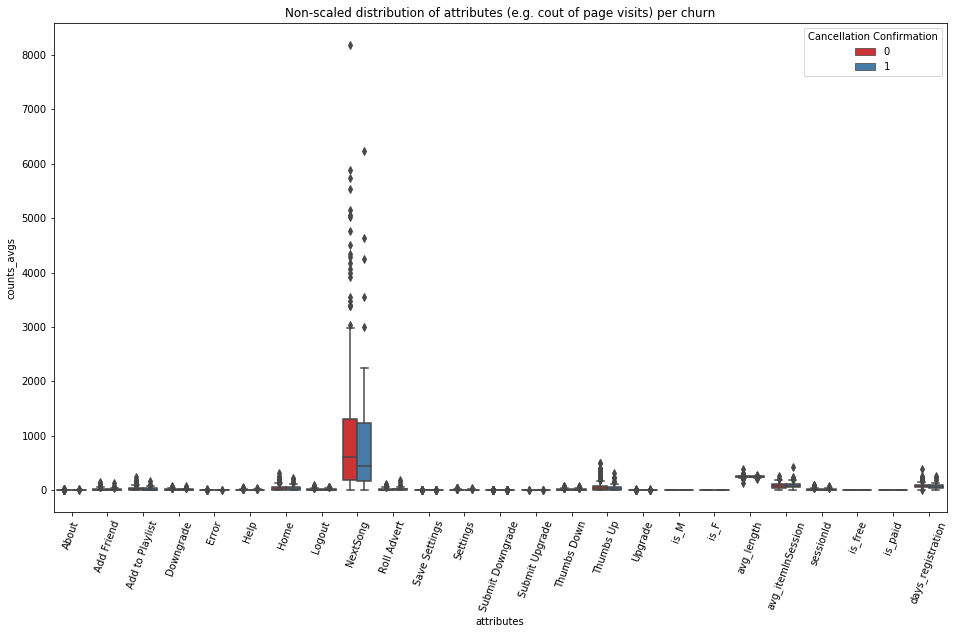

In [16]:
# Plot user attributes for churn vs. non-churn; non-scaled version

results = users_by_attributes.toPandas()
label_column = 'Cancellation Confirmation'
results.drop(columns=['Cancel', 'userId'], axis = 1, inplace = True)

df_plot = pd.melt(results, id_vars=label_column, \
            var_name = 'attributes', value_name='counts_avgs')
# Create grouped boxplot
rcParams['figure.figsize'] = 16,9;
sns.boxplot(x="attributes", y="counts_avgs", hue=label_column, data=df_plot, palette="Set1");
plt.title('Non-scaled distribution of attributes (e.g. cout of page visits) per churn')
plt.xticks(rotation=70);

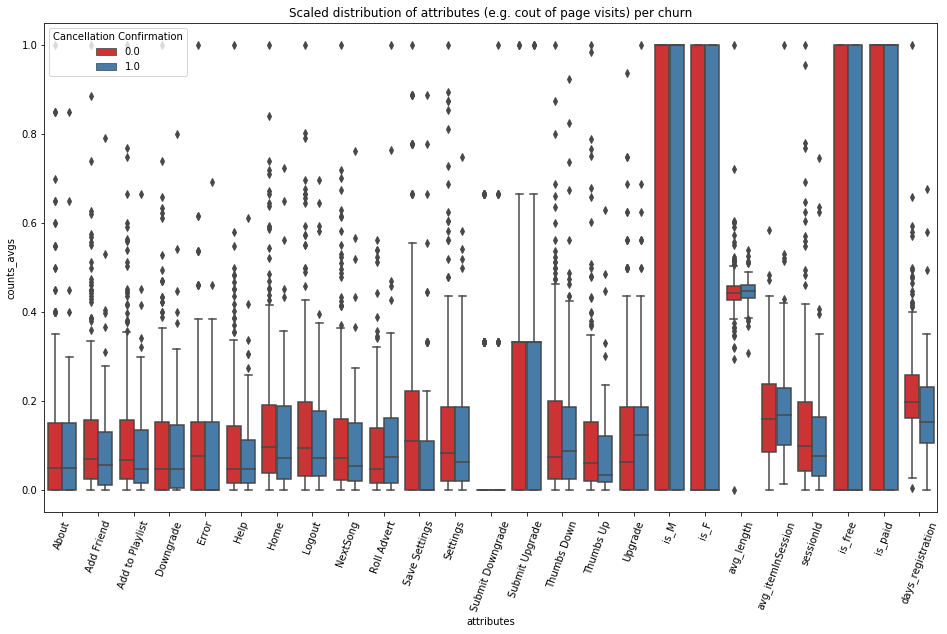

In [17]:
# Plot user attributes for churn vs. non-churn; scaled version

min_max_scaler = preprocessing.MinMaxScaler()
results_scaled = min_max_scaler.fit_transform(results.values)
results_scaled = pd.DataFrame(results_scaled)
results_scaled.columns = results.columns

df_plot = pd.melt(results_scaled, id_vars=label_column, \
            var_name = 'attributes', value_name='counts_avgs')

# Grouped boxplot
rcParams['figure.figsize'] = 16,9;
sns.boxplot(x="attributes", y="counts_avgs", hue=label_column, data=df_plot, palette="Set1");
plt.title('Scaled distribution of attributes (e.g. cout of page visits) per churn')
plt.xticks(rotation=70);

# Feature Engineering
To build the attributes for a model, the attributes were calculated over different timeframes and subesquently only the attributes with the highest discriminatory power (between churn and non-churn users) were selected. The following steps were applied:
- **Calculate all the attributes** that vary with time **over different timeframes** (over the last last 1, 2 and 4 weeks).
- **Split data in training and test** sets (80%/20%).
- **Use a two-sample Kolmogorov–Smirnov (K-S) test** on training data **to understand the discriminatory power of attributes** (p<5%).
- **Select attributes with high discriminatory power** (K-S p-val < 5%) for the future model. To reduce collinearity, only one attribute per time-frame was selected, and attributes with a correlation coefficient higher than 0.9 with already selected attributes were also  excluded.

In [18]:
# Function to append Spark column names (with number of days over which
# the attribute has been computed; no appending means full time-frame considered)

def append_column_name(df, append_text):
    '''
    Append a string to all columns of a Spark DataFrame (except 'userId' column)

    Parameters
    ----------
    df : Spark DataFrame
        DataFrame for which column names need to be appended
    append_text : String
        Append string to add to all column names (except 'userId' column).

    Returns
    -------
    df : Spark DataFrame
        DataFrame with columns appended

    '''
        
    new_column_name_list = [name+"__"+append_text if name != 'userId' else name for name in df.columns]
    df = df.toDF(*new_column_name_list)
    
    return df

In [19]:
# Build the atributes that vary with time for various time windows
# Print the resulting Spark data frame Schema, and number of users

time_windows = [1*7, 2*7, 4*7] #last 1, 2, 4 weeks, defined in days

# Function to return Spark udf, comparing the desired time window
# (e.g. 7, 14 days) with time elapsed since user was last seen
# output column is 1/0 if records are in (time) scope or not
w = Window.partitionBy('userId')
def time_window_function(t_window):
    return F.udf(lambda timediff: \
               1 if timediff <= t_window else 0, IntegerType())

# Create the atributes that vary with time for various time windows
for time_window in time_windows:
    df = df\
            .withColumn('maxtime', F.max('time').over(w)) \
            .withColumn('timediff', F.datediff(F.col('maxtime'), F.col('time'))) \
            .withColumn('in_time_scope', time_window_function(time_window)(F.col('timediff'))) \
            .drop('maxtime', 'timediff')

    users_by_session = users_by_session_function(df, 'in_time_scope')
    users_by_session = append_column_name(users_by_session, '_'+str(time_window))

    users_by_page = users_by_page_function(df, 'in_time_scope')
    users_by_page = append_column_name(users_by_page, str(int(time_window)))

    users_by_attributes = users_by_attributes\
        .join(users_by_page, ['userId'], how='full') \
        .join(users_by_session, ['userId'], how='full') \
        .fillna(0)

# Collect results into a separate Spark data frame
users_by_attributes = spark.createDataFrame(users_by_attributes.collect())

# Describe the data frame
print(users_by_attributes.printSchema())
print('Number of users in the dataset is: {}'.format(users_by_attributes.count()))

root
 |-- userId: string (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Cancel: long (nullable = true)
 |-- Cancellation Confirmation: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- is_M: long (nullable = true)
 |-- is_F: long (nullable = true)
 |-- avg_length: double (nullable = true)
 |-- avg_itemInSession: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-

In [20]:
# Split data in training and test sets
training, test = users_by_attributes.randomSplit([0.8, 0.2], seed=42)

# Move training data to Pandas for subsequent analysis
results = training.toPandas()

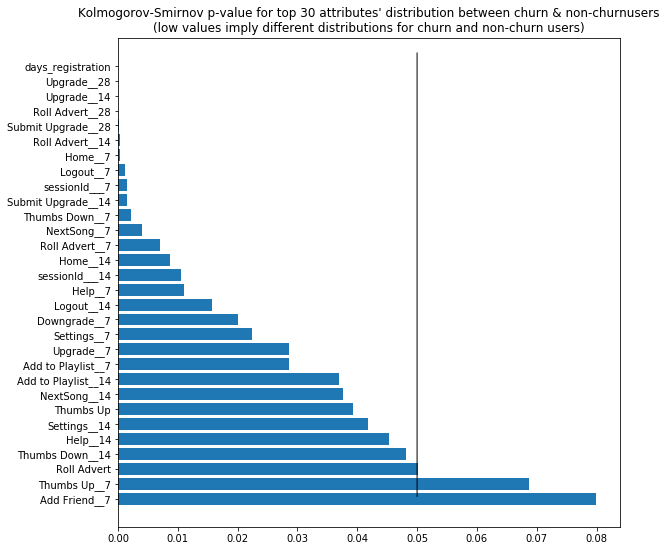

In [21]:
# Calculate Kolmogorov-Smirnov statistic with 2 samples for training data.
# K-S is a general nonparametric methods for comparing two samples.
# It is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.
# If the K-S p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

label_column = 'Cancellation Confirmation'
drop_columns = [name for name in results.columns if "Cancel" in name]
drop_columns.append('userId')
drop_columns.remove(label_column)
results.drop(columns=drop_columns, axis = 1, inplace = True)

# Define columns / attributes relevant for future model
significance_columns = set(results.columns) - set([label_column])

# Calculate K-S statistics for each attribute
KSresults = {}
for name in significance_columns:
    KSresults[name] = stats.ks_2samp(results.loc[results[label_column] == 1, name], \
               results.loc[results[label_column] == 0, name])[1]

KSresults = pd.DataFrame.from_dict(KSresults, orient='index', columns=['KS_p_val'])
KSresults = KSresults.sort_values('KS_p_val', ascending=False)

# Plot K-S results
fig, ax = plt.subplots(figsize=(9, 9))
y_pos = np.arange(len(KSresults[-30:]))
plt.barh(y_pos, KSresults[-30:]['KS_p_val'])
plt.yticks(y_pos, KSresults[-30:].index)
ax.annotate("", xy=(0.05, 0), xycoords='data',
            xytext=(0.05, len(KSresults[-30:])), textcoords='data',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc3"),
            )
plt.title('Kolmogorov-Smirnov p-value for top 30 attributes\' distribution between churn & non-churn\
users\n(low values imply different distributions for churn and non-churn users)')
plt.show()

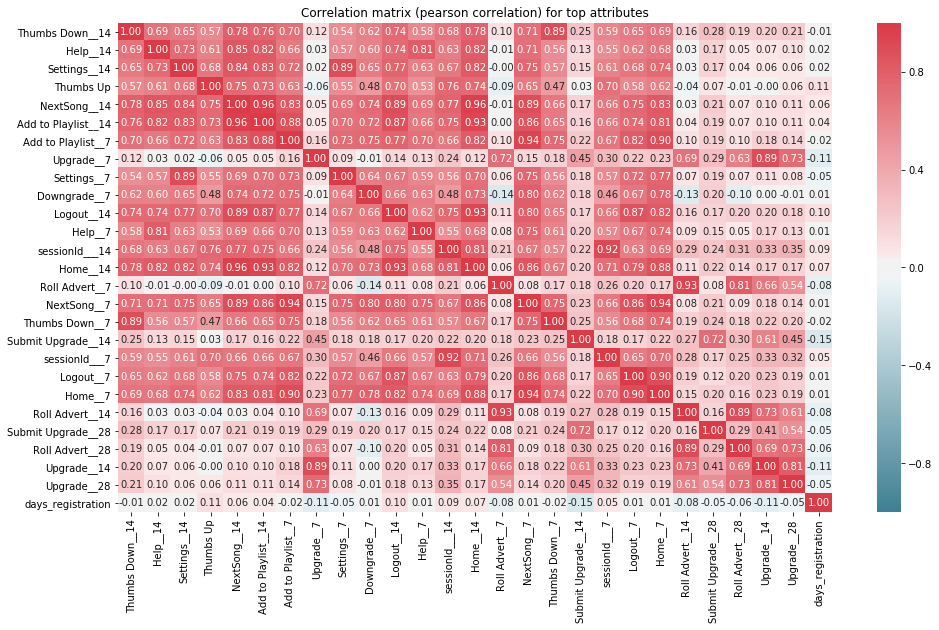

In [22]:
# Plot correlation matrix for all attributes with K-S p-val. < 5%

significance_columns = list(KSresults[KSresults['KS_p_val'] < 0.05].index)
corr_df = results[significance_columns].corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_df, annot=True, \
            fmt=".2f", cmap = cmap, vmin=-1)
plt.title('Correlation matrix (pearson correlation) for top attributes')
plt.show()

### Feature selection
Most of the selected attributes have a high degree of correlation between them - potentially introducing multicollinearity problems in the model. Especially the same visited pages over different time frames are highly correlated (e.g. Roll Advert in the last 14 days correlates highly with Roll Advent in the last 28 days and in the last 7 days).

For modelling, only one attribute per time-frame will be selected - the one which contributes the most to distinguishing churn from non-churn uses (e.g. Roll Advert in the last 28 days). Additionally, variables which have a correlation coefficient higher than 0.9 with already relected variables will also be excluded.

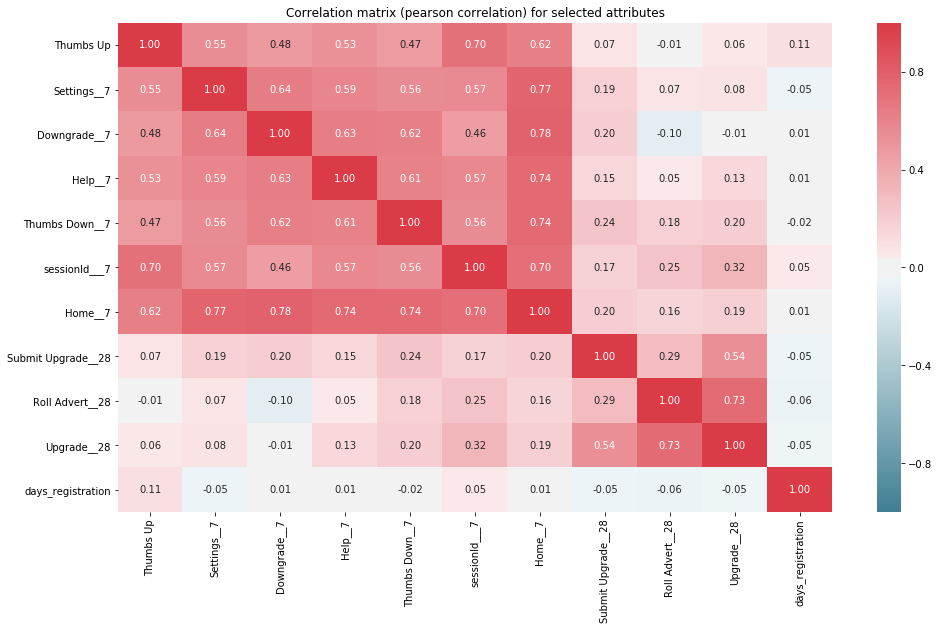

In [23]:
# Select final attributes, keeping the ones with the lowest K-S p-val
# when attribute has multiple time-frames.

final_attributes = ['Thumbs Up', 'Settings__7', \
                   'Downgrade__7', 'Help__7', 'Thumbs Down__7', \
                   'sessionId___7', 'Home__7', 'Submit Upgrade__28', \
                   'Roll Advert__28', 'Upgrade__28', 'days_registration']

corr_df = results[final_attributes].corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_df, annot=True, \
            fmt=".2f", cmap = cmap, vmin=-1)
plt.title('Correlation matrix (pearson correlation) for selected attributes')
plt.show()

# Modeling
Tow machine learning methods were applied and evaluated:
- **Logistic regression**
- **Multi-Layer Perceptron with 3 layers containing (11 (inputs), 4, 2 (predicted labels)) nodes**

Since the churned users are a fairly small subset, F1 score was used as the optimization metric. Both the Logistic Regression and the Multi-Layer Perceptron returned a probability that the user will churn. For the Logistic Regression, the threshold which maximized the F1 score was determined through a pyspark.ml function (using *fMeasureByThreshold*). For the MLP model the threshold was established by iterating through a series of thresholds and selecting the one which maximized the F1 score.

For both models model training and threshold selection was done on training data, and final model evaluation done on test data.

The Logistic Regression provided an F1 score for test of 0.76. The MLP model provided slightly better results, with an F1 score of 0.78 for test data.

In [24]:
# Prepare the logistic regression model
vecAssembler = VectorAssembler(inputCols=final_attributes, outputCol='features')

training = training\
    .select([label_column] + final_attributes)\
    .withColumnRenamed('Cancellation Confirmation', 'label')

training = vecAssembler.transform(training)

lr = LogisticRegression(maxIter=10, regParam=0.3)

# Fit the model
lrModel = lr.fit(training)

In [25]:
# Set the model threshold to maximize F-Measure
fMeasure = lrModel.summary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)
print('Maximum training F-Measure is {:0.2f}, achieved with a threshold of {:0.2f}'\
      .format(maxFMeasure[0], bestThreshold))

Maximum training F-Measure is 0.56, achieved with a threshold of 0.22


In [26]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Code adapted from: https://scikit-learn.org/stable/auto_examples/model_selection/
        plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        print('Confusion matrix, without normalization')
        print(cm)
        cm = cm.astype('float') / cm.sum()
    else:
        print("Normalized confusion matrix")
        print(cm.astype('float') / cm.sum())

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [27]:
# Prepare test data.
test = test\
    .select([label_column] + final_attributes)\
    .withColumnRenamed('Cancellation Confirmation', 'label')
test = vecAssembler.transform(test)

# Make predictions based on logistic regression and on test data
predictionandlabels = lrModel.transform(test).select(['prediction', 'label'])
y_true = predictionandlabels.select('label').toPandas()
y_pred = predictionandlabels.select('prediction').toPandas()
y_pred = y_pred.astype(int)
predictionandlabels.show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
+----------+-----+
only showing top 5 rows



Logistic regression: F-Measure for test data is 0.76

Confusion matrix, without normalization
[[79  0]
 [17  2]]


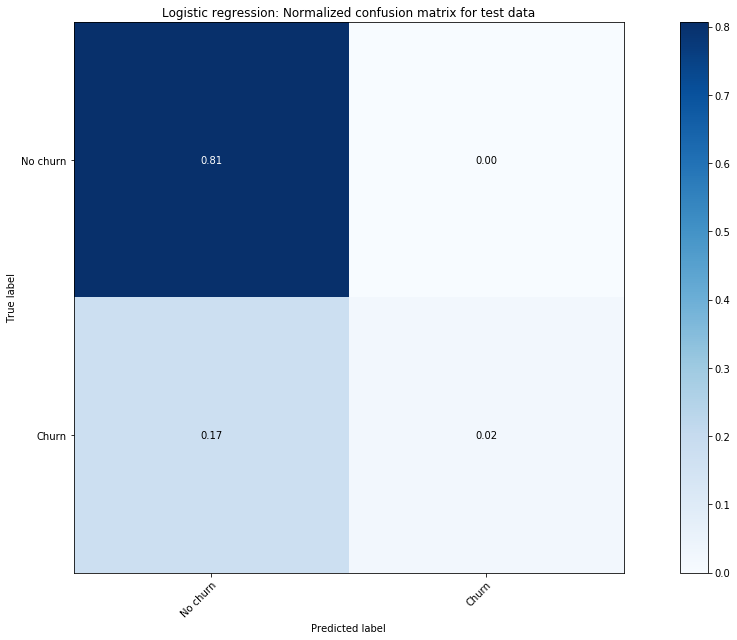

In [28]:
# logistic regression: compute F-score for test data
print('Logistic regression: F-Measure for test data is {:0.2f}\n'.\
      format(f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_true))))

# logistic regression: plot normalized confusion matrix for test data
plot_confusion_matrix(y_true, y_pred, classes=np.array(['No churn', 'Churn']),\
                      normalize=True, title='Logistic regression: Normalized confusion matrix for test data')

plt.show()

In [29]:
# Prepare the Multi-Layer Perceptron (MLP) classifier
layers = [len(training.select("features").take(1)[0][0]), 4, 2]
MLPclassifier = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)
# Fit MLP model
MLPmodel = MLPclassifier.fit(training)

In [30]:
# Calculate MLP model threshold to maximize F-Measure
y_scores = MLPmodel.transform(training).select('probability').toPandas()
y_scores = y_scores['probability'].apply(lambda x: x[1])
y_true = training.select('label').toPandas()
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
max_threshold = 0
max_F1 = 0
F1 = 0
for location, value in enumerate(thresholds):
    if recall[location] != 0 and precision[location] != 0:
        F1 = 2/(1/recall[location] + 1/precision[location])
    if F1 > max_F1:
        max_F1 = F1
        max_threshold = value

y_pred = y_scores > max_threshold

print('MLP: Maximum training F-Measure is {:0.2f}, achieved with a threshold of {:0.2f}'\
      .format(max_F1, max_threshold))

MLP: Maximum training F-Measure is 0.68, achieved with a threshold of 0.47


MLP: F-Measure for test data is 0.78

Confusion matrix, without normalization
[[74  5]
 [14  5]]


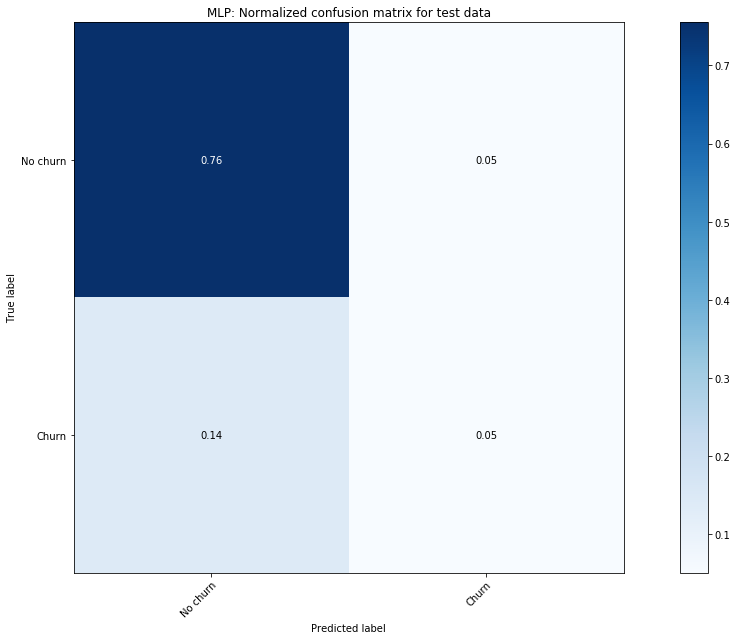

In [32]:
# Make predictions based on MLP and on test data
y_scores = MLPmodel.transform(test).select('probability').toPandas()
y_scores = y_scores['probability'].apply(lambda x: x[1])
y_true = test.select('label').toPandas()
y_pred = y_scores > max_threshold

# MLP: Compute F-score for test data
print('MLP: F-Measure for test data is {:0.2f}\n'.\
      format(f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_true))))

# Plot normalized confusion matrix for test data
plot_confusion_matrix(y_true, y_pred, classes=np.array(['No churn', 'Churn']),\
                      normalize=True, title='MLP: Normalized confusion matrix for test data')

plt.show()

# Summary
This notebook explores the Udacity Data Scientist capstone dataset (Sparkify) and builds two churn models using the Spark environment in IBM Watson Studio.

*Author:*<br>
*Dumitru Furtuna*